# Simulated Annealing results analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from crossover import *
from problems_solutions import *
from selection_algos import *
from mutations import *
from algorithms import *
from copy import deepcopy
from functools import partial
import os
from itertools import product
import json
import math
from utils import *
import seaborn as sns

from stats_test import *

In [3]:
df = pd.read_csv("../Results/sa_results.csv")

In [205]:
df["fitness_list"] = df["fitness_scores"].apply(json.loads)

df["fitness_median"] = df["fitness_list"].apply(np.median)

df = df.sort_values(by=["fitness_median"], ascending=False)

> We ran 64 different SA configurations 

In [28]:
len(df)


48

In [26]:
df.head(10)


,max_iter,L,neighbor,k,C,H,avg_fitness,std_fitness,avg_iter,avg_time,fitness_scores,fitness_list,fitness_median
5,100,50,scramble_mutation_optimized,3.0,1,0.95,73873.33,2432.00,88.37,0.67,"[71900.0, 75800.0, 75900.0, 75700.0, 72200.0, ...","[71900.0, 75800.0, 75900.0, 75700.0, 72200.0, ...",74700.0
2,100,50,scramble_mutation_optimized,3.0,1,0.99,73943.33,3136.31,90.47,0.71,"[73500.0, 64600.0, 76400.0, 72200.0, 73400.0, ...","[73500.0, 64600.0, 76400.0, 72200.0, 73400.0, ...",73900.0
20,100,50,scramble_mutation_optimized,3.0,100,0.99,73553.33,2120.49,91.87,0.70,"[75900.0, 73100.0, 69500.0, 72900.0, 75000.0, ...","[75900.0, 73100.0, 69500.0, 72900.0, 75000.0, ...",73900.0
14,100,50,scramble_mutation_optimized,3.0,10,0.95,72896.67,2269.87,68.60,0.49,"[72400.0, 66600.0, 76000.0, 70900.0, 71300.0, ...","[72400.0, 66600.0, 76000.0, 70900.0, 71300.0, ...",72950.0
1,100,50,scramble_mutation_optimized,2.0,1,0.99,72953.33,2618.11,89.93,0.66,"[68800.0, 74900.0, 73500.0, 70600.0, 73700.0, ...","[68800.0, 74900.0, 73500.0, 70600.0, 73700.0, ...",72850.0
10,100,50,scramble_mutation_optimized,2.0,10,0.99,72450.00,2730.17,89.93,0.70,"[74800.0, 76200.0, 76000.0, 74100.0, 73700.0, ...","[74800.0, 76200.0, 76000.0, 74100.0, 73700.0, ...",72750.0
19,100,50,scramble_mutation_optimized,2.0,100,0.99,72993.33,2194.98,91.37,0.67,"[69800.0, 72600.0, 74200.0, 70900.0, 71000.0, ...","[69800.0, 72600.0, 74200.0, 70900.0, 71000.0, ...",72700.0
11,100,50,scramble_mutation_optimized,3.0,10,0.99,72836.67,1960.86,87.53,0.67,"[68900.0, 73300.0, 76100.0, 73100.0, 72300.0, ...","[68900.0, 73300.0, 76100.0, 73100.0, 72300.0, ...",72600.0
29,100,50,scramble_mutation_optimized,3.0,200,0.99,72090.00,2625.43,75.47,0.61,"[67600.0, 69200.0, 73500.0, 73200.0, 72200.0, ...","[67600.0, 69200.0, 73500.0, 73200.0, 72200.0, ...",72250.0
28,100,50,scramble_mutation_optimized,2.0,200,0.99,71773.33,3407.73,79.33,0.62,"[75100.0, 73900.0, 74600.0, 68200.0, 76100.0, ...","[75100.0, 73900.0, 74600.0, 68200.0, 76100.0, ...",72150.0


In [206]:
# ADICIONEI: RITA
df_summary = df[['neighbor', 'C', 'H', 'fitness_list','avg_time']]
df_exploded = df_summary.explode("fitness_list")
df_exploded['fitness_list'] = df_exploded['fitness_list'].astype(float)
df_exploded = df_exploded.rename(columns={"fitness_list": "fitness"})
df_exploded

,neighbor,C,H,fitness,avg_time
5,scramble_mutation_optimized,1,0.95,71900.0,0.67
5,scramble_mutation_optimized,1,0.95,75800.0,0.67
5,scramble_mutation_optimized,1,0.95,75900.0,0.67
5,scramble_mutation_optimized,1,0.95,75700.0,0.67
5,scramble_mutation_optimized,1,0.95,72200.0,0.67
...,...,...,...,...,...
33,scramble_mutation_optimized,200,0.90,49000.0,0.11
33,scramble_mutation_optimized,200,0.90,43500.0,0.11
33,scramble_mutation_optimized,200,0.90,53300.0,0.11
33,scramble_mutation_optimized,200,0.90,51500.0,0.11


## Final fitness plots

### Aggregate by neighboor operator (mutation) 

> Scramble mutation as the neighbor operator seem to be better than swap mutation.
Scramble mutation introduces larger exploratory moves by shuffling two or more indexes in the solution, escaping the local minima when the temperature is high (high C value) that stabilize when as the "temperature cools" (C value decreases), against swap mutation which only swaps two indexes, being slower and less exploratory for neighboring solutions. 

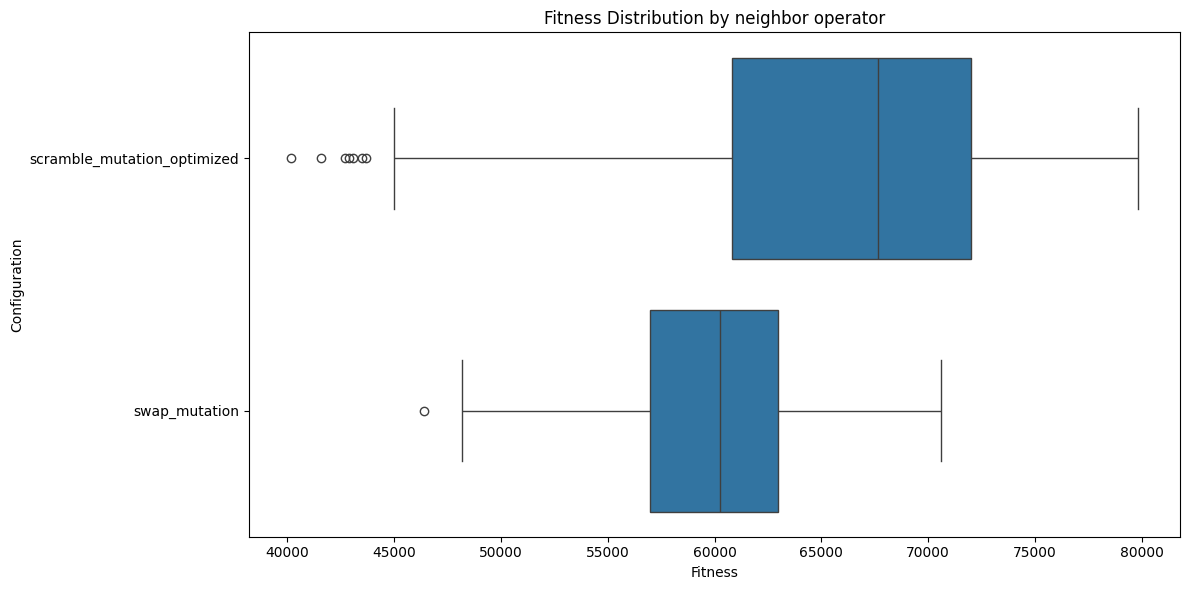

In [35]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "mutation": row["neighbor"]
        })

plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("mutation")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="mutation", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by neighbor operator")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-top:22px;padding-bottom:5px; padding-left:10px">
  <h4>STATS</h4>
</div>


In [90]:
neighbor_summary = (
    df_exploded.groupby("neighbor")["fitness"]
               .agg(["count", "mean", "median", "std", "min", "max"])
               .round(3)
               .sort_values("median")
               
)
neighbor_summary

,count,mean,median,std,min,max
neighbor,,,,,,
swap_mutation,360,59915.833,60250.0,4327.286,46400.0,70600.0
scramble_mutation_optimized,1080,65900.370,67650.0,7656.438,40200.0,79800.0


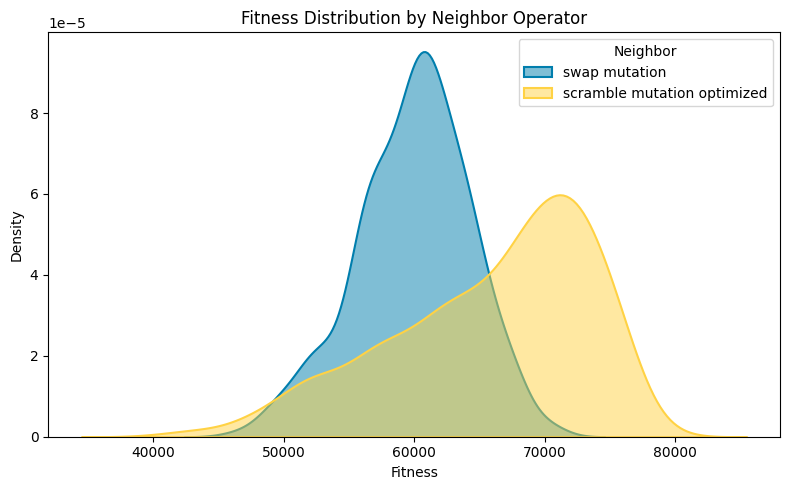

In [149]:
palette = {"swap_mutation": "#007ead",
           "scramble_mutation_optimized":"#ffd244"}

plot_fitness_distribution(
    df=df_exploded,
    column="neighbor",
    palette=palette,
    title="Fitness Distribution by Neighbor Operator",
    figsize=(8,5)
)

In [111]:
scramble = df_exploded[df_exploded['neighbor']=='scramble_mutation_optimized']['fitness'].values
swap = df_exploded[df_exploded['neighbor']=='swap_mutation']['fitness'].values


mann_whitney_u_test(scramble,swap,0.01)


Mann-Whitney U statistic: 295011.000
P-value: 4.480e-49
----------------------------------------------------------------------------------------------------
REJECT H0: Groups differ significantly.
Rank-biserial correlation: 0.518


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-left:10px">
  <strong>Nota:</strong> Rank-biserial correlation evaluates the effect size. It provides an estimate of the strength and direction of the relationship between the independent groups and the outcome variable. 

  Ranges from -1 to 1: -1 meaning perfect negative relationship, 0 means no relationship, 1 means positive relationship.

  - positive values means the first group tends to have higher ranks (higher values).
  - negative values means the first group tends to have lower ranks than the second.
  
</div>



<div style="border-left: 5px solid green; background-color: #e6f4ea;;padding-bottom:5px; padding-left:10px">
   In this case, the groups differ significantly, with scramble mutation presenting higher values.
</div>


### Aggregate by scramble mutation and scramble size

> Higher k factor in scramble mutation means lower scramble sizes; <br>

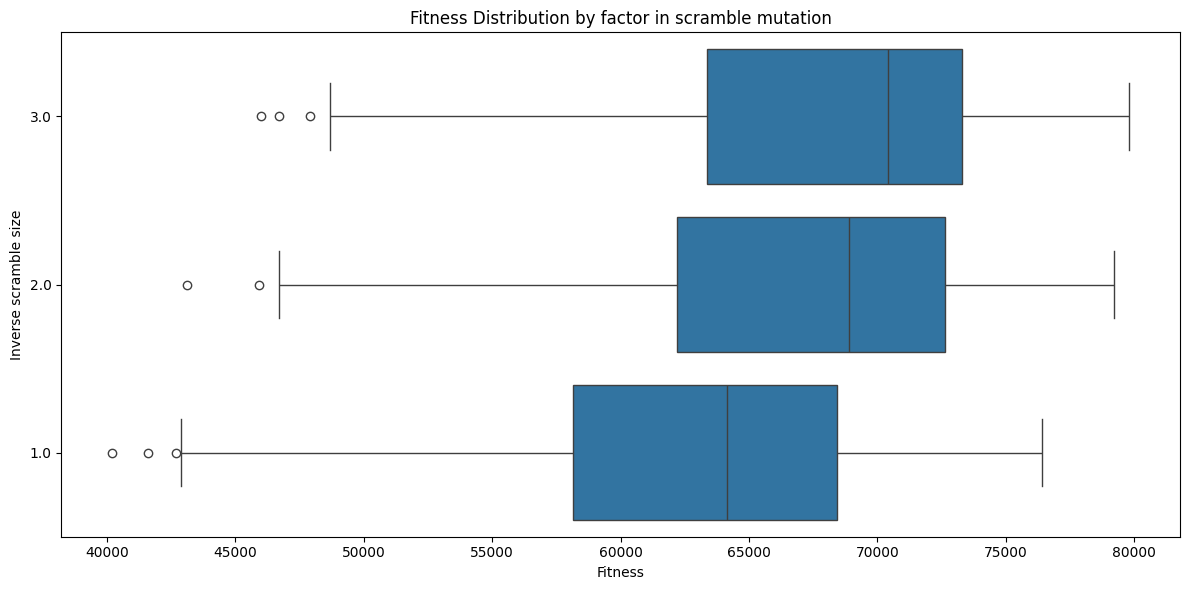

In [32]:

records = []
for _, row in df.iterrows():
    if row["neighbor"] == "swap_mutation":
        continue
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "mutation": row["neighbor"],
            "k": row["k"]
        })
    
    
plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("k")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["k"] = plot_df["k"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="k", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by factor in scramble mutation")
plt.xlabel("Fitness")
plt.ylabel("Inverse scramble size")
plt.tight_layout()
plt.show()


### Aggregate by C value 

> Higher C (100, 200) mean higher initial probability of accepting worse solutions. <br>
Lower values (1, 10) tend to be more greedy and less exploratory, with low probability of accepting worse solutions and in this case tend to show an overall better median fitness

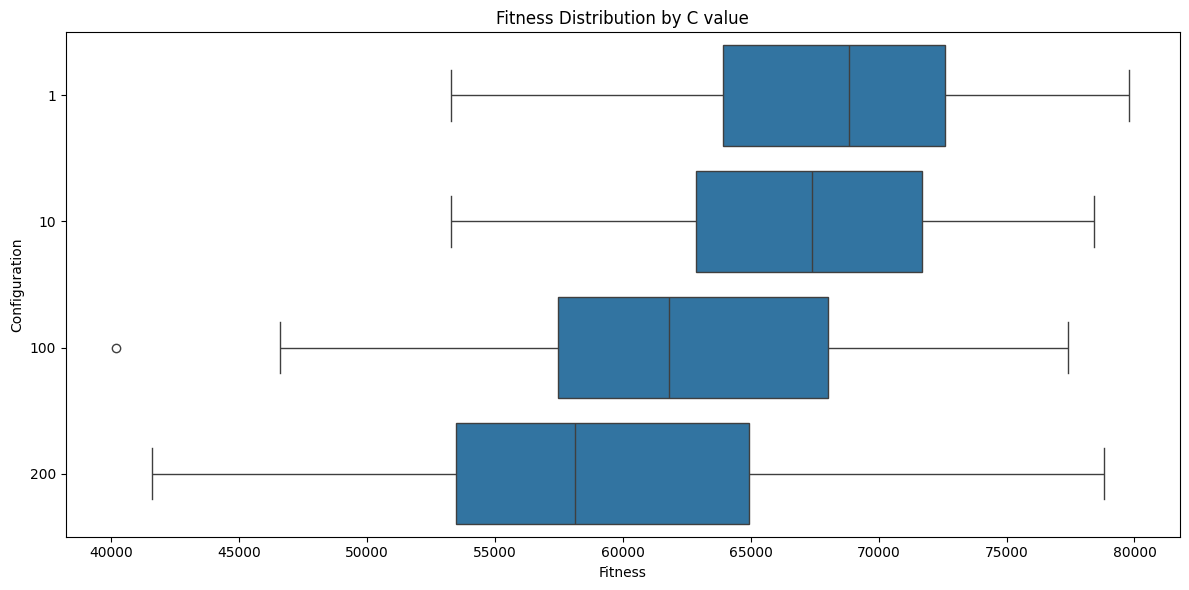

In [207]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "C": row["C"]
        })
        
plot_df = pd.DataFrame(records)


sorted_labels = (
    plot_df.groupby("C")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["C"] = plot_df["C"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="C", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by C value")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-top:22px;padding-bottom:5px; padding-left:10px">
  <h4>STATS</h4>
</div>


In [208]:
c_summary = (
    df_exploded.groupby("C")["fitness"]
               .agg(["count", "mean", "median", "std", "min", "max"])
               .round(3)
               .sort_values("median")
               
)
c_summary

,count,mean,median,std,min,max
C,,,,,,
200,360,59621.944,58150.0,8022.704,41600.0,78800.0
100,360,62683.889,61800.0,7092.482,40200.0,77400.0
10,360,67192.500,67400.0,5324.053,53300.0,78400.0
1,360,68118.611,68850.0,5595.120,53300.0,79800.0


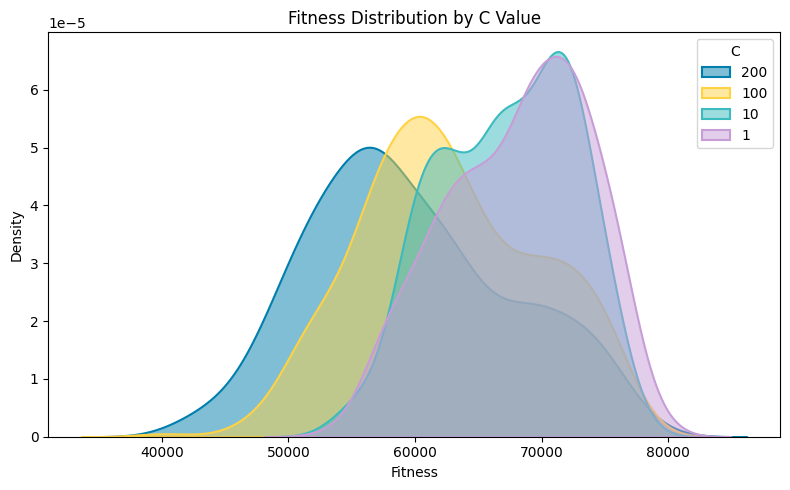

In [218]:

palette = {200: "#007ead",
           100:"#ffd244",
           10: "#3bbabf",
           1: "#c79dd7"}

plot_fitness_distribution(
    df=df_exploded,
    column="C",
    palette=palette,
    title="Fitness Distribution by C Value",
    figsize=(8,5)
)

In [220]:
config_groups = [
    grp["fitness"].values
    for _, grp in df_exploded.groupby("C", observed=True)
]
kruskal_wallis_test(config_groups)

Kruskal-Wallis H-test statistic: 287.423
P-value: 5.242e-62
Kendall's W effect size: 0.067
----------------------------------------------------------------------------------------------------
REJECT H0: At least one configuration has significantly different fitness scores.


<div style="border-left: 5px solid green; background-color: #e6f4ea;;padding-bottom:5px; padding-left:10px">
  <strong>Nota:</strong> Kendall's W effect size: Goes form 0 to 1. Where 1 means perfect separation amongst groups. There's no overlap. While 0 means groups are very similar.

  - 0.1-0.2 small efect size: somewhat different, but still overlap.
  - 0.3 - 0.5: moderate
  - \>0.5: large effect size
  
</div>


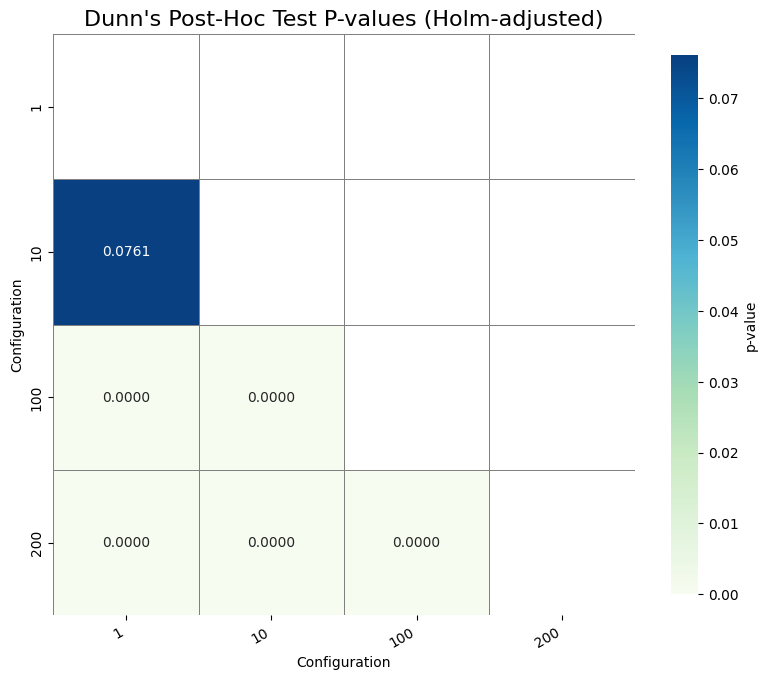

In [222]:
dunn_results= run_dunn_posthoc(df_exploded, 'fitness', 'C','holm')
plot_dunn_results(dunn_results,figsize=(8,8))

<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-left:10px">
  <strong>Dunn's test</strong> is used to check the difference between the groups -  to see which groups differ. Lower values mean that they are different (as in <0.01)
  
  If value is above alpha:  there is no statistically significant difference between those two groups at that alpha level. Which means we don't have enough evidence to reject the null hyphothesis.
</div>


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-left:10px">
  In this case, there's significant difference between all expect for 10 and 1.
</div>

### Aggregate by H value

>H is the decay rate of the C value <br>
Higher H means a slower decay of the C value, which means a more exploratory algorithm <br>
Higher values of H (0.99) mean that the decay of C will be slower so the algorithm will accept worse solutions more often, and in this case the median fitness is higher. 

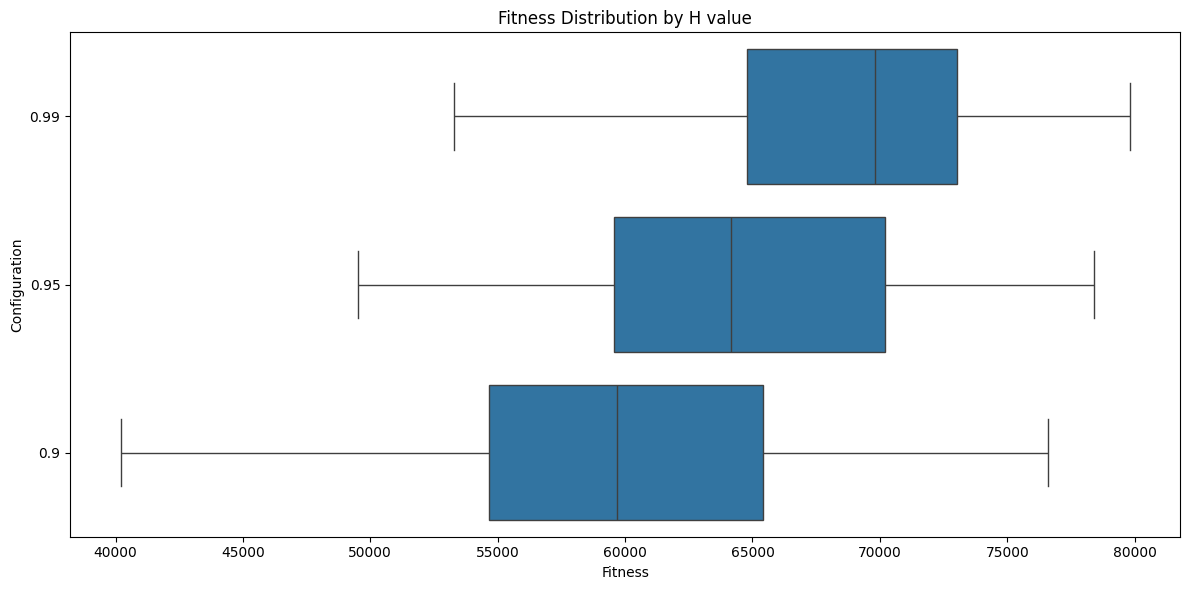

In [123]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "H": row["H"]
        })
    
plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("H")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["H"] = plot_df["H"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="H", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by H value")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-top:22px;padding-bottom:5px; padding-left:10px">
  <h4>STATS</h4>
</div>


In [126]:
h_summary = (
    df_exploded.groupby("H")["fitness"]
               .agg(["count", "mean", "median", "std", "min", "max"])
               .round(3)
               .sort_values("median")
               
)
h_summary

,count,mean,median,std,min,max
H,,,,,,
0.90,480,59686.667,59700.0,7253.797,40200.0,76600.0
0.95,480,64604.792,64150.0,6469.943,49500.0,78400.0
0.99,480,68921.250,69800.0,5385.762,53300.0,79800.0


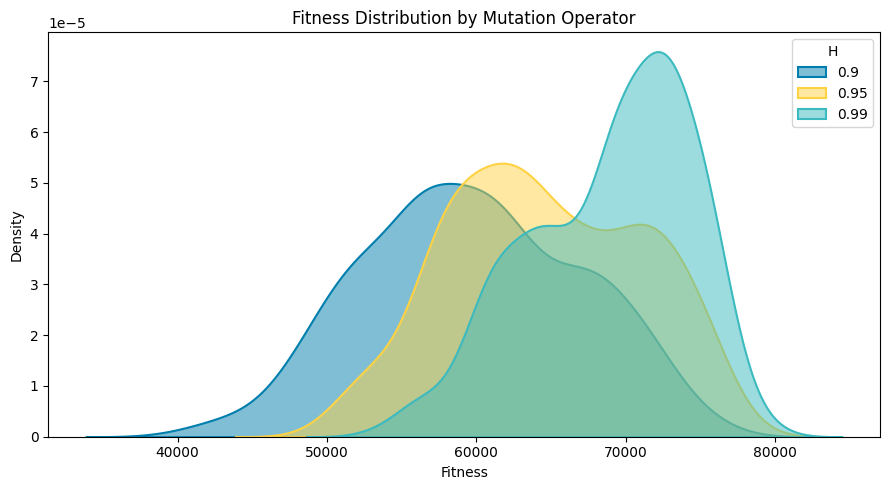

In [171]:

palette = {
    0.90: "#007ead",
    0.95: "#ffd244",
    0.99: "#3bbabf"
}


plot_fitness_distribution(
    df=df_exploded,
    column="H",
    palette=palette,
    title="Fitness Distribution by Mutation Operator",
    figsize=(9,5)
)


In [172]:
h_hroup = [
    grp["fitness"].values
    for _, grp in df_exploded.groupby("H", observed=True)
]
kruskal_wallis_test(h_hroup)

Kruskal-Wallis H-test statistic: 359.861
P-value: 7.198e-79
Kendall's W effect size: 0.125
----------------------------------------------------------------------------------------------------
REJECT H0: At least one configuration has significantly different fitness scores.


In [176]:
dunn_results= run_dunn_posthoc(df_exploded, 'fitness', 'H','holm')
dunn_results.round(5)

,0.90,0.95,0.99
0.90,1.0,0.0,0.0
0.95,0.0,1.0,0.0
0.99,0.0,0.0,1.0


# Fitness per generation plots

In [ ]:
results_file = "../Results/avg_fitness_by_generation_sa.csv"

final_res = pd.read_csv(results_file)

final_res["fitness_by_gen"] = final_res["fitness_by_gen"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_by_gen"].apply(lambda x: x[-1])

final_res["best_fitness"] = final_res["best_fitness"].apply(json.loads)

final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)

> As the generations increase (from generation 50 until 200) a higher scramble size (k=1, dark blue line) achieve a better significant better fitness than smaller sizes, probably by allowing continuous exploration of the local search space.

> A small scramble sizes (k=2 and k=3) with a relative high C value (C=10, 200) (orange line and light blue lines) result in a decrease of fitness of the current solution after 150 iterations, probably small capacity of exploration of the local search space (smaller k values) with a high probability of accepting worse solutions (high C value) at low temperatures (after 150 iterations).  

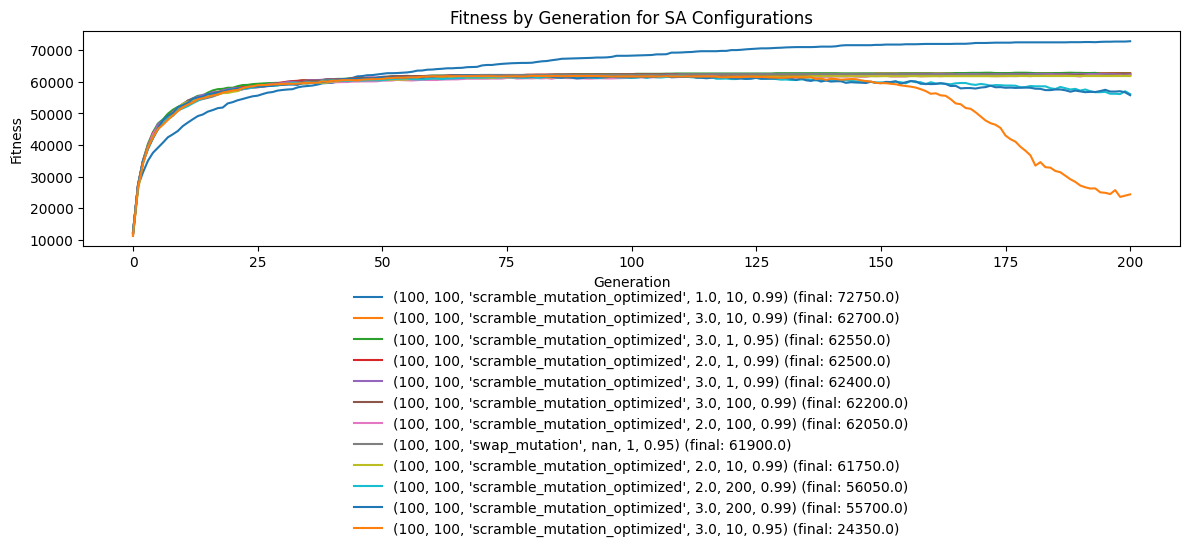

"(100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99)"

In [182]:

plt.figure(figsize=(12, max(6, 0.4 * len(final_res_sorted))))
for _, row in final_res_sorted.iterrows():
    fitness_curve = row["fitness_by_gen"]
    label = f"{row['configuration']} (final: {row['final_fitness']})"
    plt.plot(fitness_curve, label=label)
    
plt.title("Fitness by Generation for SA Configurations")
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False)
plt.tight_layout()
plt.show()


best_config = final_res_sorted.iloc[0]
best_config["configuration"]


<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-top:22px;padding-bottom:5px; padding-left:10px">
  <h4>STATS</h4>
</div>


In [240]:
df_exploded = (
    final_res_sorted[["configuration", "best_fitness"]]
    .explode("best_fitness")
)
df_exploded

,configuration,best_fitness
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",75300.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",72000.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",77900.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",74800.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",74400.0
...,...,...
3,"(100, 100, 'scramble_mutation_optimized', 3.0,...",64100.0
3,"(100, 100, 'scramble_mutation_optimized', 3.0,...",65300.0
3,"(100, 100, 'scramble_mutation_optimized', 3.0,...",61600.0
3,"(100, 100, 'scramble_mutation_optimized', 3.0,...",57300.0


In [ ]:
config_summary = (
    df_exploded.groupby("configuration",observed='True')["best_fitness"]
               .agg(["count", "mean", "median", "std", "min", "max"])
               .round(3)
               .sort_values("median")
)

config_summary

,count,mean,median,std,min,max
configuration,,,,,,
"(100, 100, 'scramble_mutation_optimized', 2.0, 10, 0.99)",100,61566.0,61750.0,3741.177,53100.0,70200.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 10, 0.95)",100,62394.0,62200.0,3306.767,55900.0,71200.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 1, 0.99)",100,62161.0,62400.0,3679.753,51700.0,71300.0
"(100, 100, 'swap_mutation', nan, 1, 0.95)",100,62398.0,62400.0,3050.550,55700.0,70600.0
"(100, 100, 'scramble_mutation_optimized', 2.0, 1, 0.99)",100,62253.0,62500.0,3530.486,52700.0,68700.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 10, 0.99)",100,62334.0,62700.0,3666.232,54400.0,72900.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 100, 0.99)",100,63434.0,62800.0,3262.961,54300.0,71800.0
"(100, 100, 'scramble_mutation_optimized', 2.0, 100, 0.99)",100,62769.0,63000.0,3070.014,54500.0,68700.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 1, 0.95)",100,62652.0,63050.0,3549.889,54500.0,68900.0


In [189]:
config_groups = [
    grp["best_fitness"].values
    for _, grp in df_exploded.groupby("configuration", observed=True)
]
kruskal_wallis_test(config_groups)

Kruskal-Wallis H-test statistic: 289.042
P-value: 1.778e-55
Kendall's W effect size: 0.022
----------------------------------------------------------------------------------------------------
REJECT H0: At least one configuration has significantly different fitness scores.


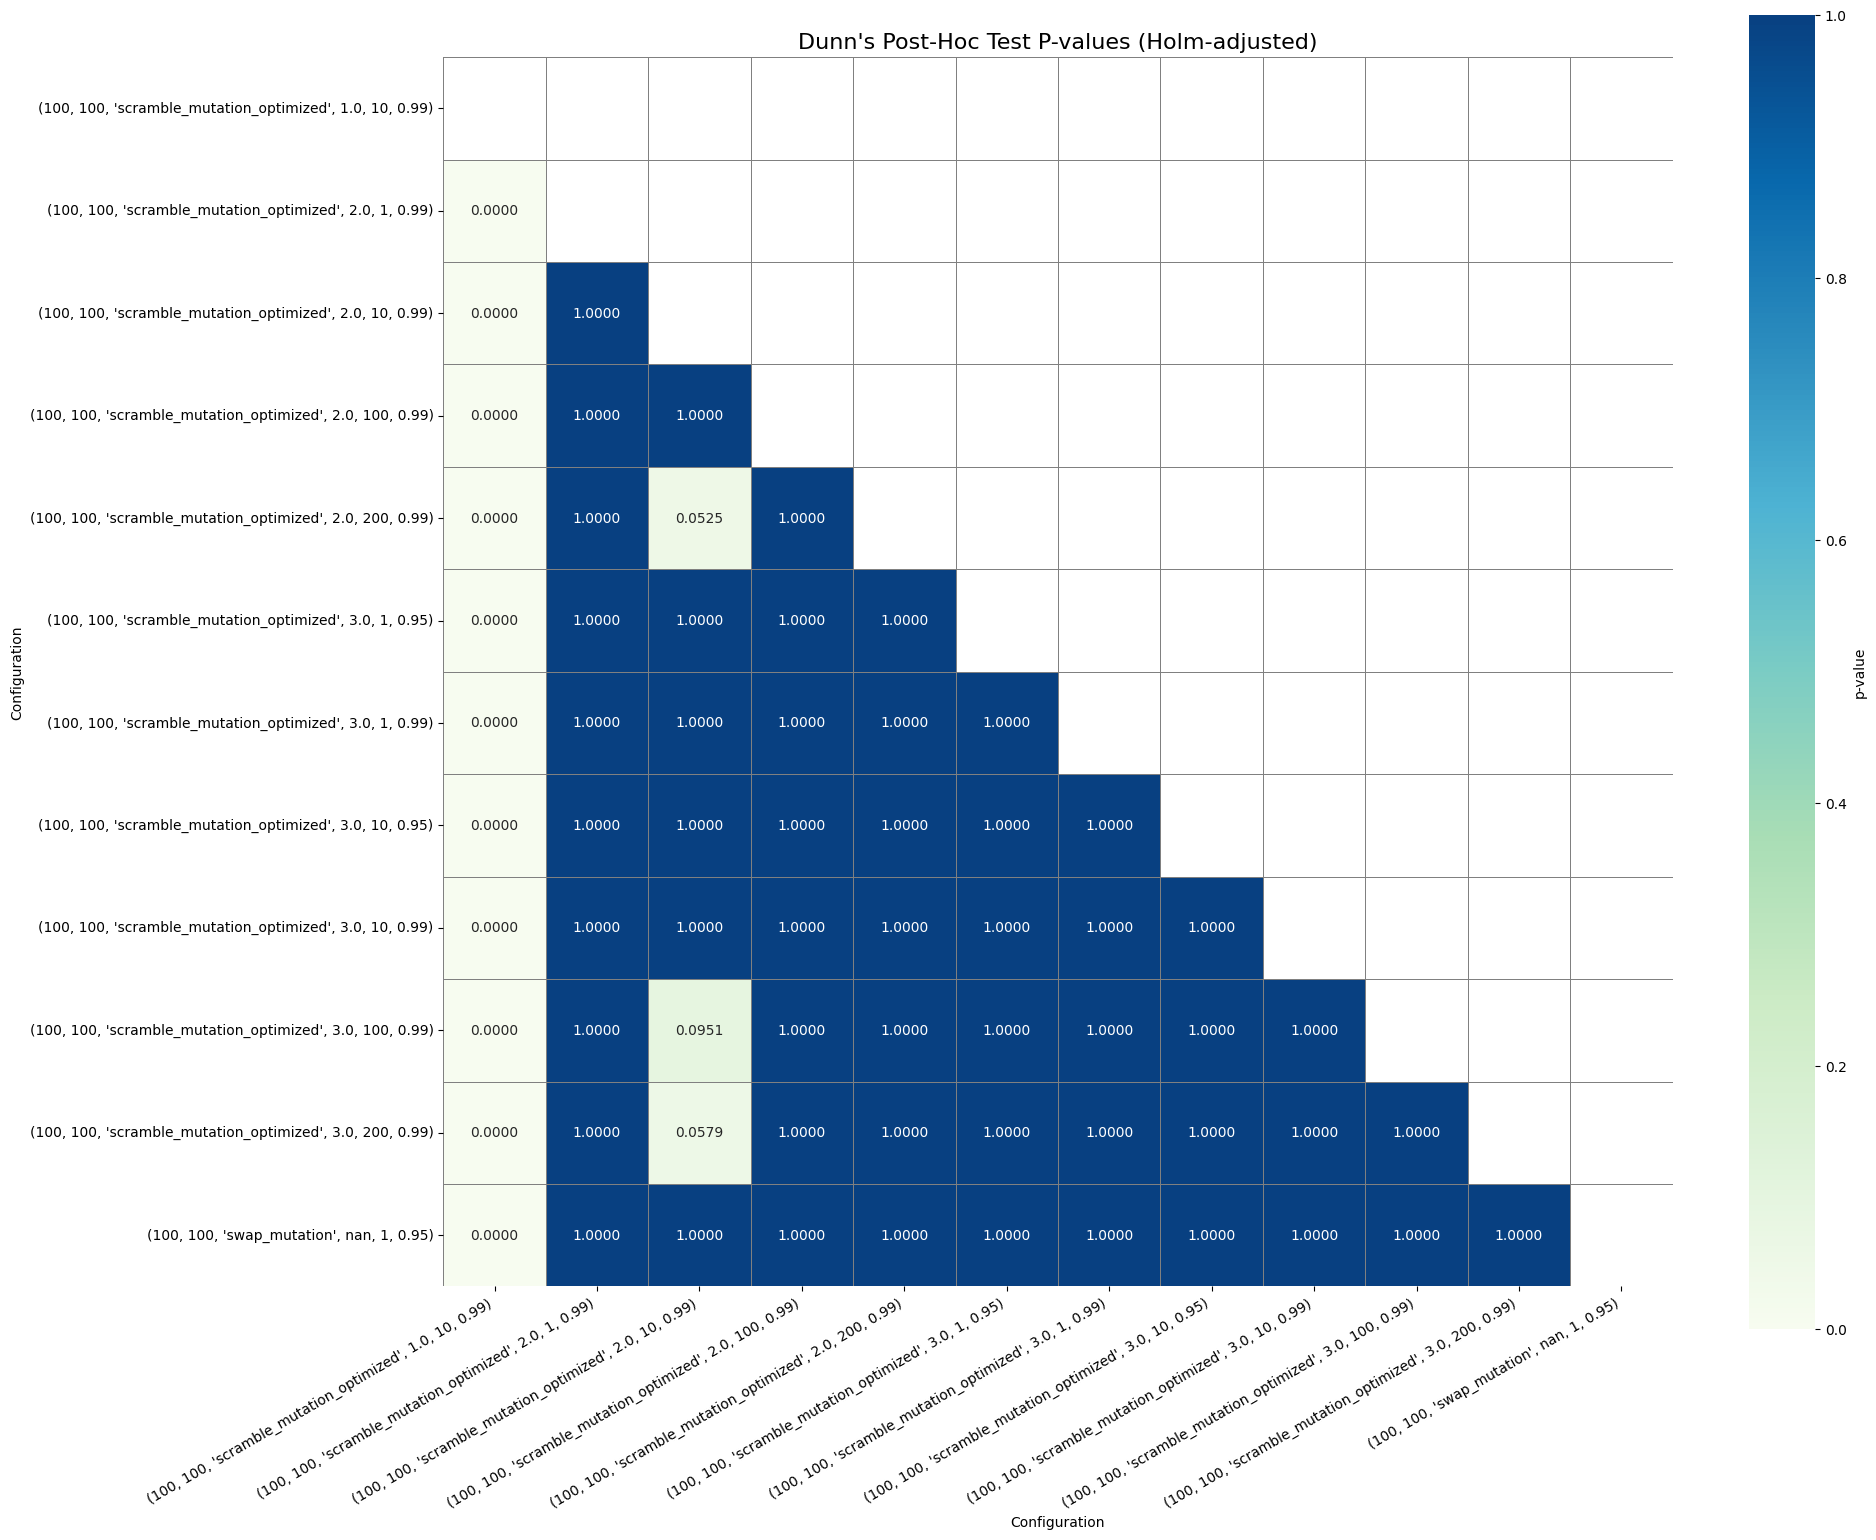

In [191]:
dunn_results= run_dunn_posthoc(df_exploded, 'best_fitness', 'configuration','holm')
plot_dunn_results(dunn_results)

> Pode-se aplicar depois só aos top 3 como no outro. É de esperar o único que difere de todos é o laranja.

## Top 3

<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-left:10px">
    Peguei do GA e alterei, provavelmente tem de se alterar o nome das variáveis.
</div>


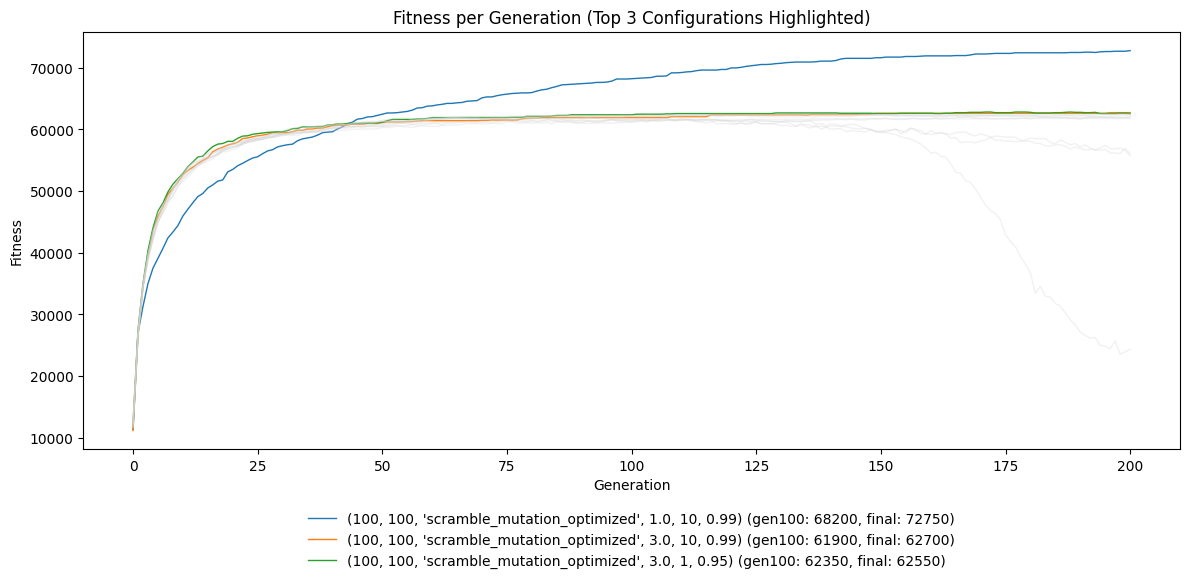

In [225]:
top_3 = final_res_sorted.head(3)
top_configs = top_3["configuration"].tolist()

plt.figure(figsize=(12, max(6, 0.4 * len(final_res_sorted))))

for _, row in final_res_sorted.iterrows():
    fitness_curve = row["fitness_by_gen"]
    config = row["configuration"]
    gen100_median = fitness_curve[100]
    label = f"{row['configuration']} (gen100: {round(gen100_median)}, final: {round(row['final_fitness'])})"

    if config in top_configs:
        plt.plot(fitness_curve, label=label, linewidth=1)
    else:
        plt.plot(fitness_curve, color="lightgray", linewidth=1, alpha=0.3)

plt.title("Fitness per Generation (Top 3 Configurations Highlighted)")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)
plt.tight_layout()
plt.show()


In [248]:
top_3_conf = top_3['configuration'].unique()
filtered_df = df_exploded[df_exploded["configuration"].isin(top_3_conf)]
filtered_df

,configuration,best_fitness
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",75300.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",72000.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",77900.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",74800.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...",74400.0
...,...,...
0,"(100, 100, 'scramble_mutation_optimized', 3.0,...",63600.0
0,"(100, 100, 'scramble_mutation_optimized', 3.0,...",64300.0
0,"(100, 100, 'scramble_mutation_optimized', 3.0,...",65400.0
0,"(100, 100, 'scramble_mutation_optimized', 3.0,...",61800.0


In [265]:
top_3['configuration'].unique()

array(["(100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99)",
       "(100, 100, 'scramble_mutation_optimized', 3.0, 10, 0.99)",
       "(100, 100, 'scramble_mutation_optimized', 3.0, 1, 0.95)"],
      dtype=object)

In [249]:
summary = (
    filtered_df
    .groupby("configuration")["best_fitness"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .round(3)
    .sort_values("median")
)

summary

,count,mean,median,std,min,max
configuration,,,,,,
"(100, 100, 'scramble_mutation_optimized', 3.0, 10, 0.99)",100,62334.0,62700.0,3666.232,54400.0,72900.0
"(100, 100, 'scramble_mutation_optimized', 3.0, 1, 0.95)",100,62652.0,63050.0,3549.889,54500.0,68900.0
"(100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99)",100,73028.0,72750.0,2695.566,65000.0,78200.0


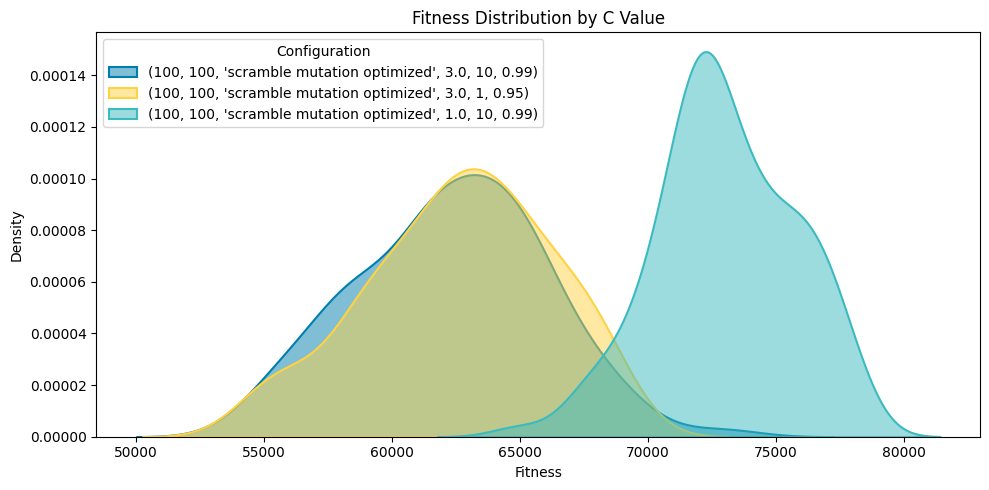

In [268]:

palette = {"(100, 100, 'scramble_mutation_optimized', 3.0, 10, 0.99)": "#007ead",
           "(100, 100, 'scramble_mutation_optimized', 3.0, 1, 0.95)":"#ffd244",
           "(100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99)": "#3bbabf"}
plot_fitness_distribution(
    df=filtered_df,
    column="configuration",
    palette=palette,
    title="Fitness Distribution by C Value",
    figsize=(10,5),
    x='best_fitness'
)

In [252]:
top_3_groups = [
    grp["best_fitness"].values
    for _, grp in filtered_df.groupby("configuration", sort=False)
]

kruskal_wallis_test(top_3_groups)

Kruskal-Wallis H-test statistic: 192.515
P-value: 1.570e-42
Kendall's W effect size: 0.321
----------------------------------------------------------------------------------------------------
REJECT H0: At least one configuration has significantly different fitness scores.


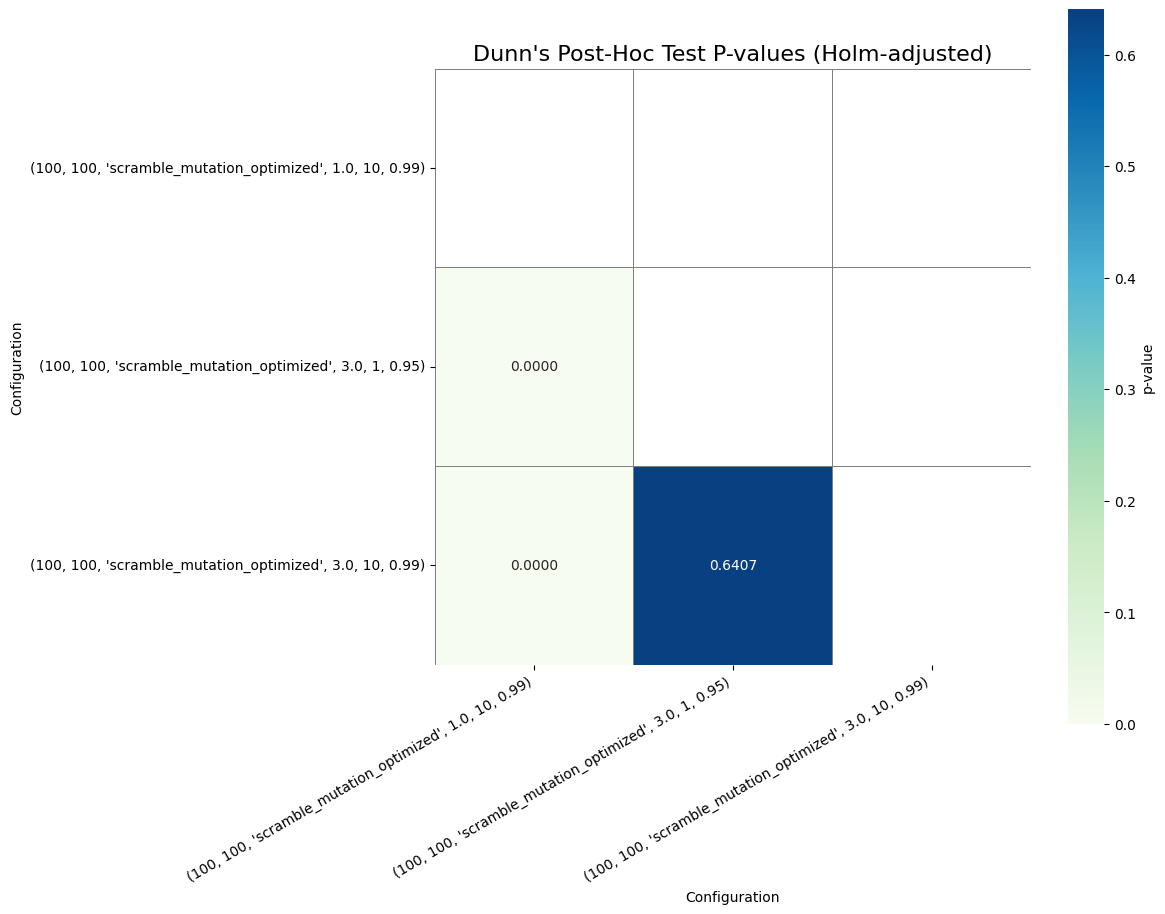

In [258]:
dunn_results= run_dunn_posthoc(filtered_df, 'best_fitness', 'configuration','holm')
plot_dunn_results(dunn_results,figsize=(12,12))

<div style="border-left: 5px solid green; background-color: #e6f4ea; padding-left:10px">
    Como é de esperar (100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99) é o que difere estatisticamente dos outros.
</div>
